<a href="https://colab.research.google.com/github/mobley-trent/kaggle/blob/master/sales_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SALES PREDICTION ON TIME SERIES DATA FOR FAVORITA STORES IN ECUADOR

![image](https://play-lh.googleusercontent.com/WL6Pav83X_hSwHTMVr5o_aJZjQS3AOnW97egsjODzHJO9q7rYcTwXbLosqkW7F5IQqk)

In this notebook, we will explore the problem of sales prediction for various product families sold at Favorita stores in Ecuador. We will make use of time series data and various statistical techniques to uncover trends and patterns in the data, and build predictive models to forecast future sales.

We will start by loading and exploring the data, which includes daily sales data for different product families at Favorita stores over a period of time. Initially, we use `LinearRegression` from `sklearn` to fit the data into a linear regression. We will then use the `statsmodels` library to create a linear regression model for predicting sales, along with other techniques such as the `DeterministicProcess` for uncovering trends, and the `CalendarFourier` for modeling seasonality.

In addition to these techniques, we will also create a custom hybrid model that combines two different models in an object-oriented approach. This will allow us to take advantage of the strengths of each model and create a more accurate and robust sales prediction model.

By the end of this notebook, we will have a better understanding of the sales trends and patterns at Favorita stores, and will have built a reliable model for predicting future sales. This information can be used by store managers and decision-makers to optimize inventory, staffing, and other aspects of their business operations.

In [1]:
from google.colab import files
files.upload() # upload kaggle.json

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

!kaggle kernels list — user YOUR_USER — sort-by dateRun
!kaggle competitions download -c store-sales-time-series-forecasting

Saving kaggle.json to kaggle.json
kaggle.json
usage: kaggle
       [-h]
       [-v]
       {competitions,c,datasets,d,kernels,k,config}
       ...
kaggle: error: unrecognized arguments: — user YOUR_USER — sort-by dateRun
 94% 20.0M/21.4M [00:01<00:00, 30.5MB/s]
100% 21.4M/21.4M [00:01<00:00, 19.7MB/s]


In [2]:
!unzip store-sales-time-series-forecasting.zip

Archive:  store-sales-time-series-forecasting.zip
  inflating: holidays_events.csv     
  inflating: oil.csv                 
  inflating: sample_submission.csv   
  inflating: stores.csv              
  inflating: test.csv                
  inflating: train.csv               
  inflating: transactions.csv        


In [3]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

plt.style.use('ggplot')

In [4]:
# Clone repo
!pip install git+https://github.com/scikit-learn-contrib/py-earth@v0.2dev

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/scikit-learn-contrib/py-earth (to revision v0.2dev) to /tmp/pip-req-build-nrr6q3vq
  Running command git clone --filter=blob:none --quiet https://github.com/scikit-learn-contrib/py-earth /tmp/pip-req-build-nrr6q3vq
  Running command git checkout -b v0.2dev --track origin/v0.2dev
  Switched to a new branch 'v0.2dev'
  Branch 'v0.2dev' set up to track remote branch 'v0.2dev' from 'origin'.
  Resolved https://github.com/scikit-learn-contrib/py-earth to commit 400f84d435b7277124535c09ca32132c1d0eaa74
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn-contrib-py-earth: filename=sklearn_contrib_py_earth-0.1.0+16.g400f84d-cp38-cp38-linux_x86_64.whl size=5810317 sha256=7186e6dc32c3506387cc4a028e6a77da42323c87fa15ab2db218aa7f99c094de
  Stored in directory: /tmp/pip-ephem-wheel-cache-pulsryje/wheels/8a/33/e4/b577aeaf3435222ffd76339bd728390afc103237af5c

## EXPLORATORY DATA ANALYSIS

In [5]:
data_oil = pd.read_csv('oil.csv')
data_holi = pd.read_csv('holidays_events.csv')
data_stores = pd.read_csv('stores.csv')
data_trans = pd.read_csv('transactions.csv')
test_data = pd.read_csv('test.csv')
train_data = pd.read_csv('train.csv')

data_oil.name = 'Oil data'
data_holi.name = 'Holiday events'
data_stores.name = 'Stores data'
data_trans.name = 'Transaction data'
test_data.name = 'Test data'
train_data.name = 'Train data'

In [6]:
datasets = [data_oil, data_holi, data_stores, data_trans, test_data, train_data]

for df in datasets:
    print("DataFrame name:", df.name)
    print("Shape:", df.shape)
    print("Info:")
    print(df.info())
    print("Descriptive statistics:")
    print(df.describe())
    print("=====================================")
    print()

DataFrame name: Oil data
Shape: (1218, 2)
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB
None
Descriptive statistics:
        dcoilwtico
count  1175.000000
mean     67.714366
std      25.630476
min      26.190000
25%      46.405000
50%      53.190000
75%      95.660000
max     110.620000

DataFrame name: Holiday events
Shape: (350, 6)
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non

In [7]:
for df in datasets:
    print("DataFrame name:", df.name)
    print("Head:")
    print(df.head())
    print("=====================================")
    print()

DataFrame name: Oil data
Head:
         date  dcoilwtico
0  2013-01-01         NaN
1  2013-01-02       93.14
2  2013-01-03       92.97
3  2013-01-04       93.12
4  2013-01-07       93.20

DataFrame name: Holiday events
Head:
         date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False  

DataFrame name: Stores data
Head:
   store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2   

In [8]:
for dataset in datasets:
    print(f"Exploring {dataset.name}...")
    print(f"Shape: {dataset.shape}")
    print(f"Columns: {dataset.columns}")
    print(f"Missing values: {dataset.isnull().sum().sum()}")
    print(f"Duplicated data: {dataset.duplicated().sum()}")
    print("=====================================")
    print("")

Exploring Oil data...
Shape: (1218, 2)
Columns: Index(['date', 'dcoilwtico'], dtype='object')
Missing values: 43
Duplicated data: 0

Exploring Holiday events...
Shape: (350, 6)
Columns: Index(['date', 'type', 'locale', 'locale_name', 'description', 'transferred'], dtype='object')
Missing values: 0
Duplicated data: 0

Exploring Stores data...
Shape: (54, 5)
Columns: Index(['store_nbr', 'city', 'state', 'type', 'cluster'], dtype='object')
Missing values: 0
Duplicated data: 0

Exploring Transaction data...
Shape: (83488, 3)
Columns: Index(['date', 'store_nbr', 'transactions'], dtype='object')
Missing values: 0
Duplicated data: 0

Exploring Test data...
Shape: (28512, 5)
Columns: Index(['id', 'date', 'store_nbr', 'family', 'onpromotion'], dtype='object')
Missing values: 0
Duplicated data: 0

Exploring Train data...
Shape: (3000888, 6)
Columns: Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')
Missing values: 0
Duplicated data: 0



We investigate to see if there is a relationship between crude oil price and sales. Ecuador is an oil producer and the economy is heavily dependent on oil prices.

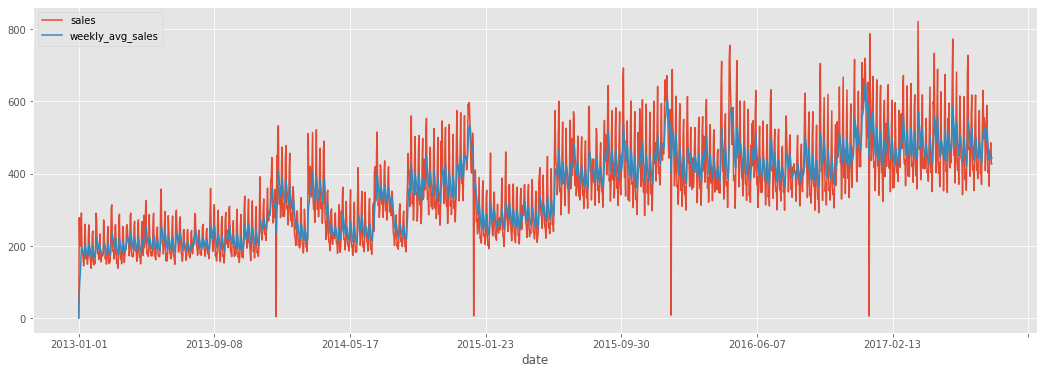

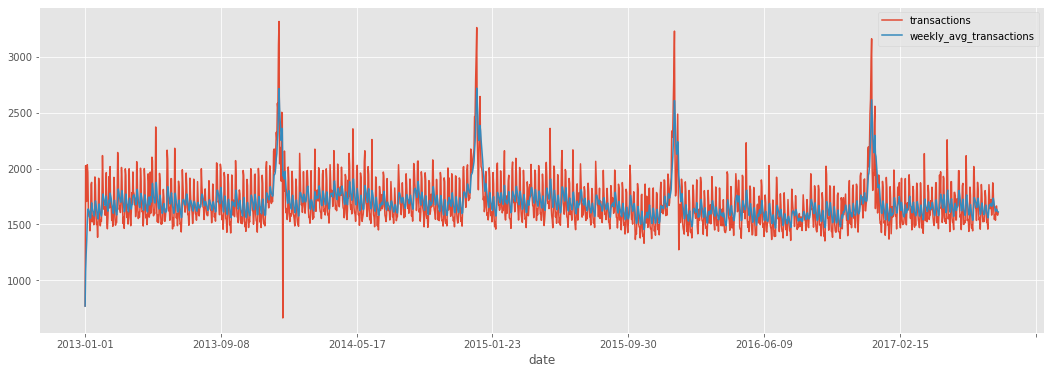

In [9]:
avg_sales = train_data.groupby('date').agg({'sales': 'mean'}).reset_index()
avg_sales['weekly_avg_sales'] = avg_sales['sales'].ewm(span=7, adjust=False).mean()
ax1 = avg_sales.plot(x= 'date', y= ['sales', 'weekly_avg_sales'], figsize=(18,6))

avg_transactions = data_trans.groupby('date').agg({'transactions': 'mean'}).reset_index()
avg_transactions['weekly_avg_transactions'] = avg_transactions['transactions'].ewm(span=7, adjust=False).mean()
ax2 = avg_transactions.plot(x= 'date', y= ['transactions', 'weekly_avg_transactions'], figsize=(18,6))

In [10]:
fig = px.line(data_oil, x='date', y='dcoilwtico')
# Customize the plot
fig.update_layout(title='Crude Oil Prices over Time',
                   xaxis_title='Date',
                   yaxis_title='Crude Oil Price')
# Show the plot
fig.show()

In [11]:
train_data['date'] = pd.to_datetime(train_data['date'])
train_data['day_of_week'] = train_data['date'].dt.dayofweek
train_data['month'] = train_data['date'].dt.month
train_data['year'] = train_data['date'].dt.year

data_grouped_day = train_data.groupby(['day_of_week']).mean()['sales']
data_grouped_month = train_data.groupby(['month']).mean()['sales']
data_grouped_year = train_data.groupby(['year']).mean()['sales']

In [12]:
# Create a bar chart for sales by day of the week
fig1 = go.Figure(go.Bar(x=data_grouped_day.index, y=data_grouped_day))
fig1.update_layout(title='Sales by Day of Week', )

# Create a bar chart for sales by month
fig2 = go.Figure(go.Bar(x=data_grouped_month.index, y=data_grouped_month))
fig2.update_layout(title='Sales by Month')

# Create a bar chart for sales by year
fig3 = go.Figure(go.Bar(x=data_grouped_year.index, y=data_grouped_year))
fig3.update_layout(title='Sales by Year')

# Create a subplot with 1 row and 3 columns
fig = make_subplots(rows=1, cols=3)

# Add each figure to a subplot
fig.add_trace(fig1.data[0], row=1, col=1)
fig.update_xaxes(title_text='Day of Week', row=1, col=1)
fig.update_yaxes(title_text='Sales', row=1, col=1)
fig.add_trace(fig2.data[0], row=1, col=2)
fig.update_xaxes(title_text='Month', row=1, col=2)
fig.update_yaxes(title_text='Sales', row=1, col=2)
fig.add_trace(fig3.data[0], row=1, col=3)
fig.update_xaxes(title_text='Year', row=1, col=3)
fig.update_yaxes(title_text='Sales', row=1, col=3)

# Set the title for the entire subplot
fig.update_layout(title='Sales by Date')

fig.show()

In [13]:
def time_plot(data, family=None):

    if family:
        family_data = data.loc[data["family"] == family]

        family_data['date'] = pd.to_datetime(family_data['date'])
        family_data['day_of_week'] = family_data['date'].dt.dayofweek
        family_data['month'] = family_data['date'].dt.month
        family_data['year'] = family_data['date'].dt.year

        data_grouped_day = family_data.groupby(['day_of_week']).mean()['sales']
        data_grouped_month = family_data.groupby(['month']).mean()['sales']
        data_grouped_year = family_data.groupby(['year']).mean()['sales']

    # Create a bar chart for sales by day of the week
    fig1 = go.Figure(go.Bar(x=data_grouped_day.index, y=data_grouped_day))
    fig1.update_layout(title='Sales by Day of Week')

    # Create a bar chart for sales by month
    fig2 = go.Figure(go.Bar(x=data_grouped_month.index, y=data_grouped_month))
    fig2.update_layout(title='Sales by Month')

    # Create a bar chart for sales by year
    fig3 = go.Figure(go.Bar(x=data_grouped_year.index, y=data_grouped_year))
    fig3.update_layout(title='Sales by Year')

    # Create a subplot with 1 row and 3 columns
    fig = make_subplots(rows=1, cols=3)

    # Add each figure to a subplot
    fig.add_trace(fig1.data[0], row=1, col=1)
    fig.update_xaxes(title_text='Day of Week', row=1, col=1)
    fig.update_yaxes(title_text='Sales', row=1, col=1)
    fig.add_trace(fig2.data[0], row=1, col=2)
    fig.update_xaxes(title_text='Month', row=1, col=2)
    fig.update_yaxes(title_text='Sales', row=1, col=2)
    fig.add_trace(fig3.data[0], row=1, col=3)
    fig.update_xaxes(title_text='Year', row=1, col=3)
    fig.update_yaxes(title_text='Sales', row=1, col=3)

    # Set the title for the entire subplot
    fig.update_layout(title=f'{family} Sales by Date')

    fig.show()

This function allows the user to view the general sales for a particular product family.

In [14]:
print(train_data.family.unique())

['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']


In [15]:
train_data.family.value_counts()

AUTOMOTIVE                    90936
HOME APPLIANCES               90936
SCHOOL AND OFFICE SUPPLIES    90936
PRODUCE                       90936
PREPARED FOODS                90936
POULTRY                       90936
PLAYERS AND ELECTRONICS       90936
PET SUPPLIES                  90936
PERSONAL CARE                 90936
MEATS                         90936
MAGAZINES                     90936
LIQUOR,WINE,BEER              90936
LINGERIE                      90936
LAWN AND GARDEN               90936
LADIESWEAR                    90936
HOME CARE                     90936
HOME AND KITCHEN II           90936
BABY CARE                     90936
HOME AND KITCHEN I            90936
HARDWARE                      90936
GROCERY II                    90936
GROCERY I                     90936
FROZEN FOODS                  90936
EGGS                          90936
DELI                          90936
DAIRY                         90936
CLEANING                      90936
CELEBRATION                 

In [16]:
time_plot(train_data ,'SEAFOOD')

In [17]:
# Grouping the data by family_category and calculating the mean of sales and onpromotion
data_grouped_family_types = train_data.groupby(['family']).mean()[['sales', 'onpromotion']]

# Calculating the percentage of sales
data_grouped_family_types['%_s'] = 100 * data_grouped_family_types['sales'] / data_grouped_family_types['sales'].sum()
data_grouped_family_types['%_s'] = data_grouped_family_types['%_s'].round(decimals=3)

# Sorting the data by percentage of sales in descending order
data_grouped_family_types = data_grouped_family_types.sort_values(by='%_s', ascending=False)

# Creating the plot using plotly pie chart
fig = px.pie(data_grouped_family_types, values='%_s', names=data_grouped_family_types.index,
             title='Percentage of Sales by Family Category', hole=0.4)

# Updating the layout of the plot
fig.update_traces(textposition='inside', textinfo='label+percent',
                  marker=dict(colors=px.colors.qualitative.Dark2, line=dict(color='#000000', width=1)))

# Displaying the plot
fig.show()

In [18]:
data_grouped_family_types = train_data.groupby(['family']).mean()[['sales', 'onpromotion']]

data_grouped_family_types['%_p'] = 100 * data_grouped_family_types['onpromotion'] / data_grouped_family_types['onpromotion'].sum()
data_grouped_family_types['%_p'] = data_grouped_family_types['%_p'].round(decimals = 3)

data_grouped_family_types = data_grouped_family_types.sort_values(by='%_p', ascending=False)

# Creating the plot using plotly pie chart
fig = px.pie(data_grouped_family_types, values='%_p', names=data_grouped_family_types.index,
             title='Percentage of Promotion Sales by Family Category', hole=0.5)

# Updating the layout of the plot
fig.update_traces(textposition='inside', textinfo='label+percent',
                  marker=dict(colors=px.colors.qualitative.Dark2, line=dict(color='#000000', width=1)))

fig.show()

### SALES ON HOLIDAYS

In [19]:
print(data_holi['type'].unique())
print(data_holi['type'].value_counts())

['Holiday' 'Transfer' 'Additional' 'Bridge' 'Work Day' 'Event']
Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: type, dtype: int64


In [20]:
day_type = data_holi[['date', 'type']]
avg_sales = train_data.groupby('date').agg({'sales': 'mean'}).reset_index()

day_type['date'] = pd.to_datetime(day_type['date'])
avg_sales['date'] = pd.to_datetime(avg_sales['date'])

In [21]:
print(day_type.head())
print(avg_sales.head())

        date     type
0 2012-03-02  Holiday
1 2012-04-01  Holiday
2 2012-04-12  Holiday
3 2012-04-14  Holiday
4 2012-04-21  Holiday
        date       sales
0 2013-01-01    1.409438
1 2013-01-02  278.390807
2 2013-01-03  202.840197
3 2013-01-04  198.911154
4 2013-01-05  267.873244


In [22]:
df = pd.merge_asof(day_type, avg_sales, on = 'date')
df.dropna(inplace= True)
df.reset_index(drop = True, inplace= True)

In [23]:
print(df.head())

        date      type       sales
0 2013-01-01   Holiday    1.409438
1 2013-01-05  Work Day  267.873244
2 2013-01-12  Work Day  226.295293
3 2013-02-11   Holiday  156.356672
4 2013-02-12   Holiday  173.288884


In [24]:
df_1 = df.groupby(['type']).mean()['sales']
average_holiday_sales = df_1.mean()

In [25]:
print(df_1.head())

type
Additional    479.495101
Bridge        446.750854
Event         425.660065
Holiday       367.947786
Transfer      460.521796
Name: sales, dtype: float64


In [26]:
print(f"Average holiday sales: {average_holiday_sales}")

Average holiday sales: 425.4221877399928


Text(0.5, 1.0, 'average holiday sales')

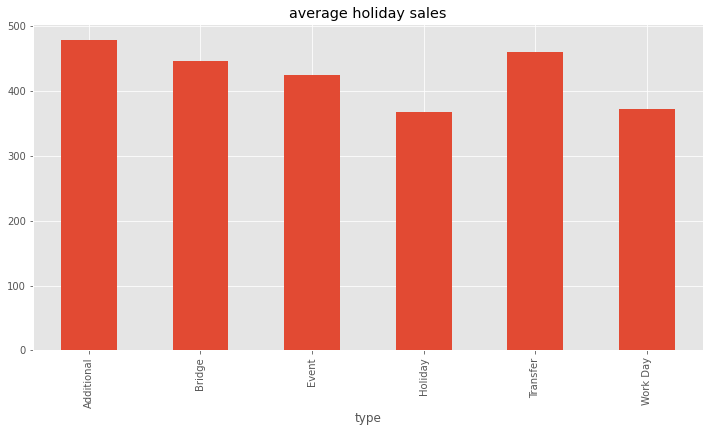

In [27]:
df_1.plot(kind='bar', figsize = (12,6)).set_title('average holiday sales')

## LINEAR REGRESSION

In [28]:
avg_sales = train_data.groupby('date').agg({'sales': 'mean'}).reset_index()
avg_sales['Time'] = np.arange(len(avg_sales.index))
avg_sales.head()

date       sales  Time
0 2013-01-01    1.409438     0
1 2013-01-02  278.390807     1
2 2013-01-03  202.840197     2
3 2013-01-04  198.911154     3
4 2013-01-05  267.873244     4

In [29]:
plt.rc(
    "figure",
    autolayout=True,
    figsize=(12, 6),
    titlesize=18,
    titleweight='bold',
)

plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)

# Use it for the Lag_1 plot later.
plot_params = dict(
    color = '0.75',
    style = ".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

%config InlineBackend.figure_format = 'retina' # You can remove

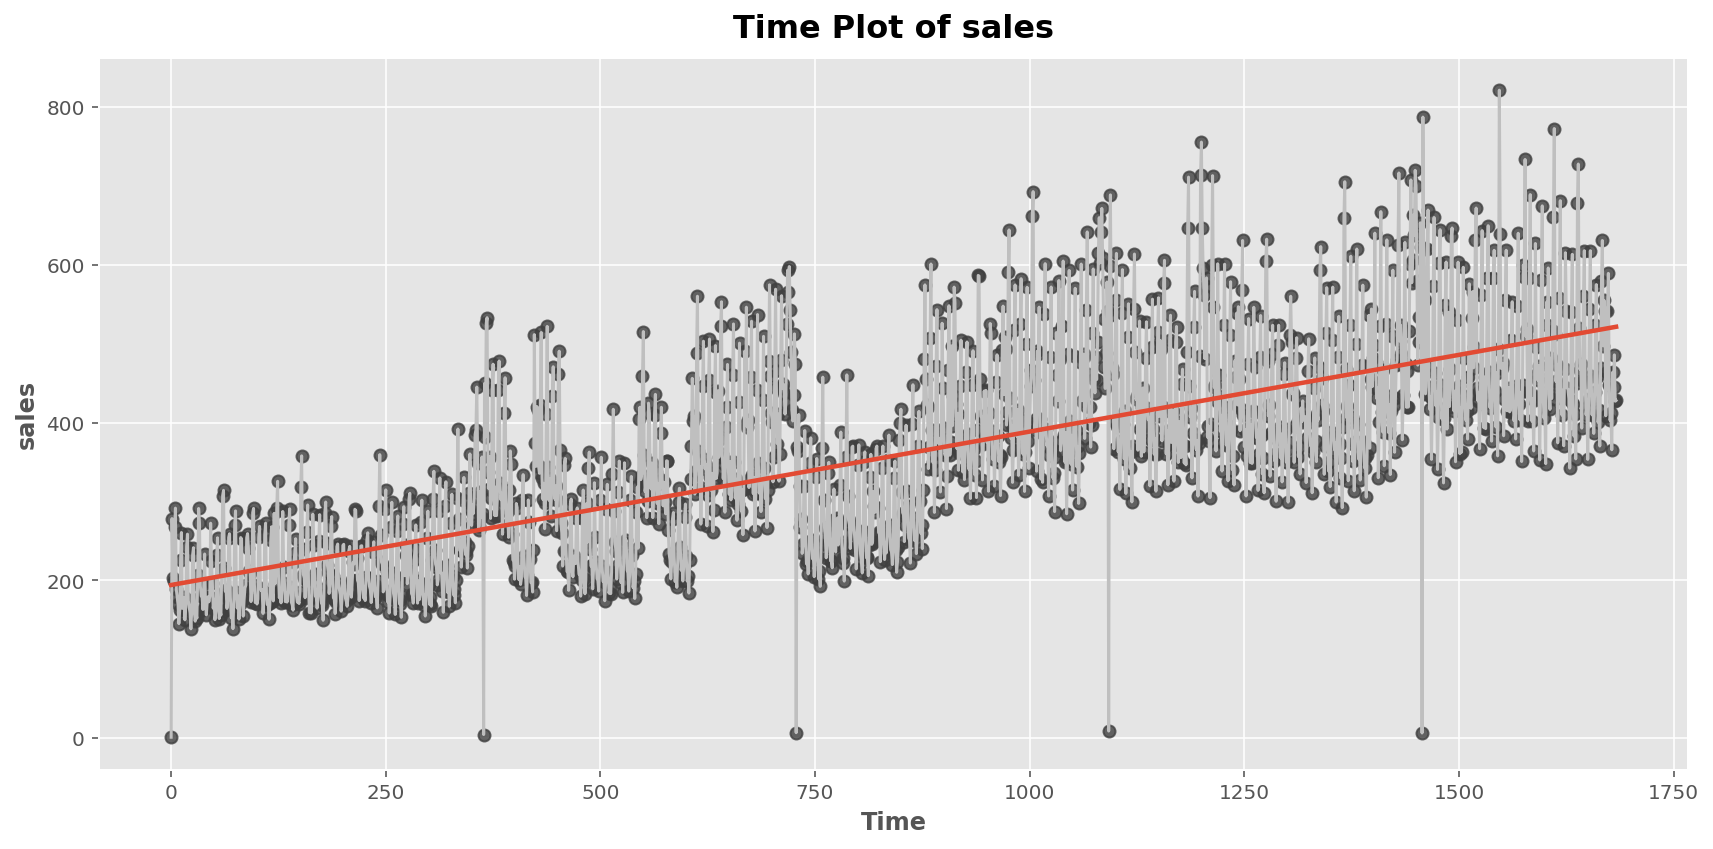

In [30]:
fig, ax = plt.subplots()
ax.plot('Time', 'sales', data=avg_sales, color='0.75')
ax = sns.regplot(x='Time', y='sales', data=avg_sales, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of sales');

In [31]:
avg_sales['Lag_1'] = avg_sales['sales'].shift(1)
avg_sales = avg_sales.reindex(columns = ['date','sales', 'Lag_1','Time'])
avg_sales.head()

date       sales       Lag_1  Time
0 2013-01-01    1.409438         NaN     0
1 2013-01-02  278.390807    1.409438     1
2 2013-01-03  202.840197  278.390807     2
3 2013-01-04  198.911154  202.840197     3
4 2013-01-05  267.873244  198.911154     4

Text(0.5, 1.0, 'Lag Plot of sales')

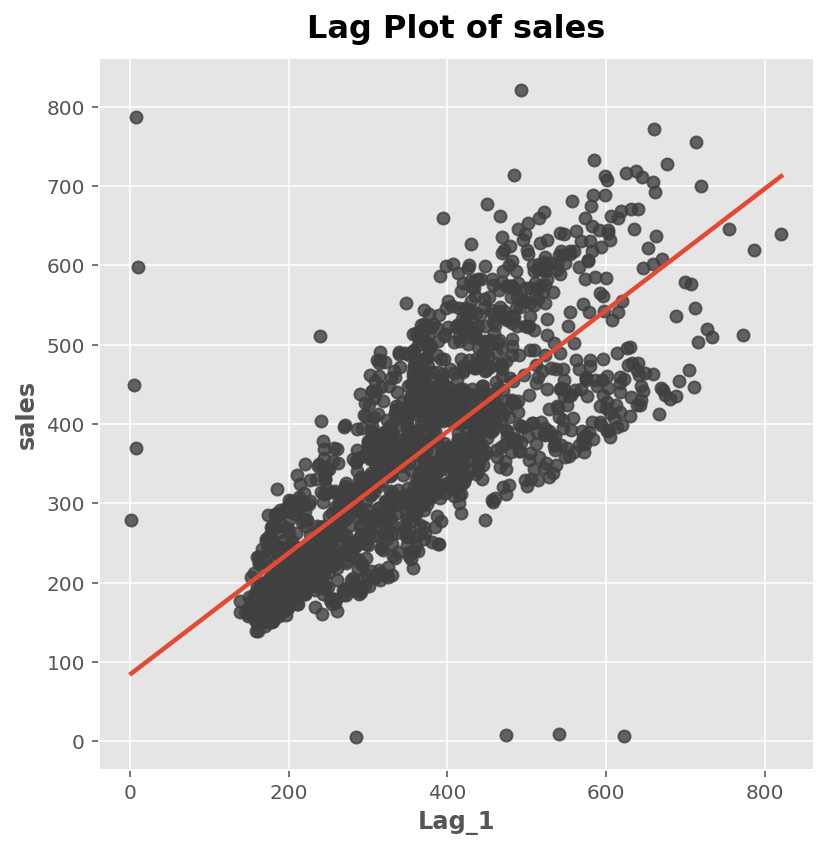

In [32]:
fig, ax = plt.subplots()
ax = sns.regplot(x = 'Lag_1', y = 'sales', data = avg_sales, ci = None, scatter_kws = dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of sales')

Lags are important in time series data because they can be used to detect patterns and trends in the data. By analyzing the relationship between a time series variable and its lags, we can identify trends such as seasonality or long-term trends, as well as relationships between the variable and other factors. Additionally, lags can be used to make predictions about future values of the time series variable.

In [33]:
from sklearn.linear_model import LinearRegression

# Training data
X = avg_sales.loc[:, ['Time']] # features
y = avg_sales.loc[:, 'sales'] # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index = X.index)
y_pred

0       194.232790
1       194.427137
2       194.621484
3       194.815831
4       195.010178
           ...    
1679    520.541320
1680    520.735667
1681    520.930014
1682    521.124361
1683    521.318708
Length: 1684, dtype: float64

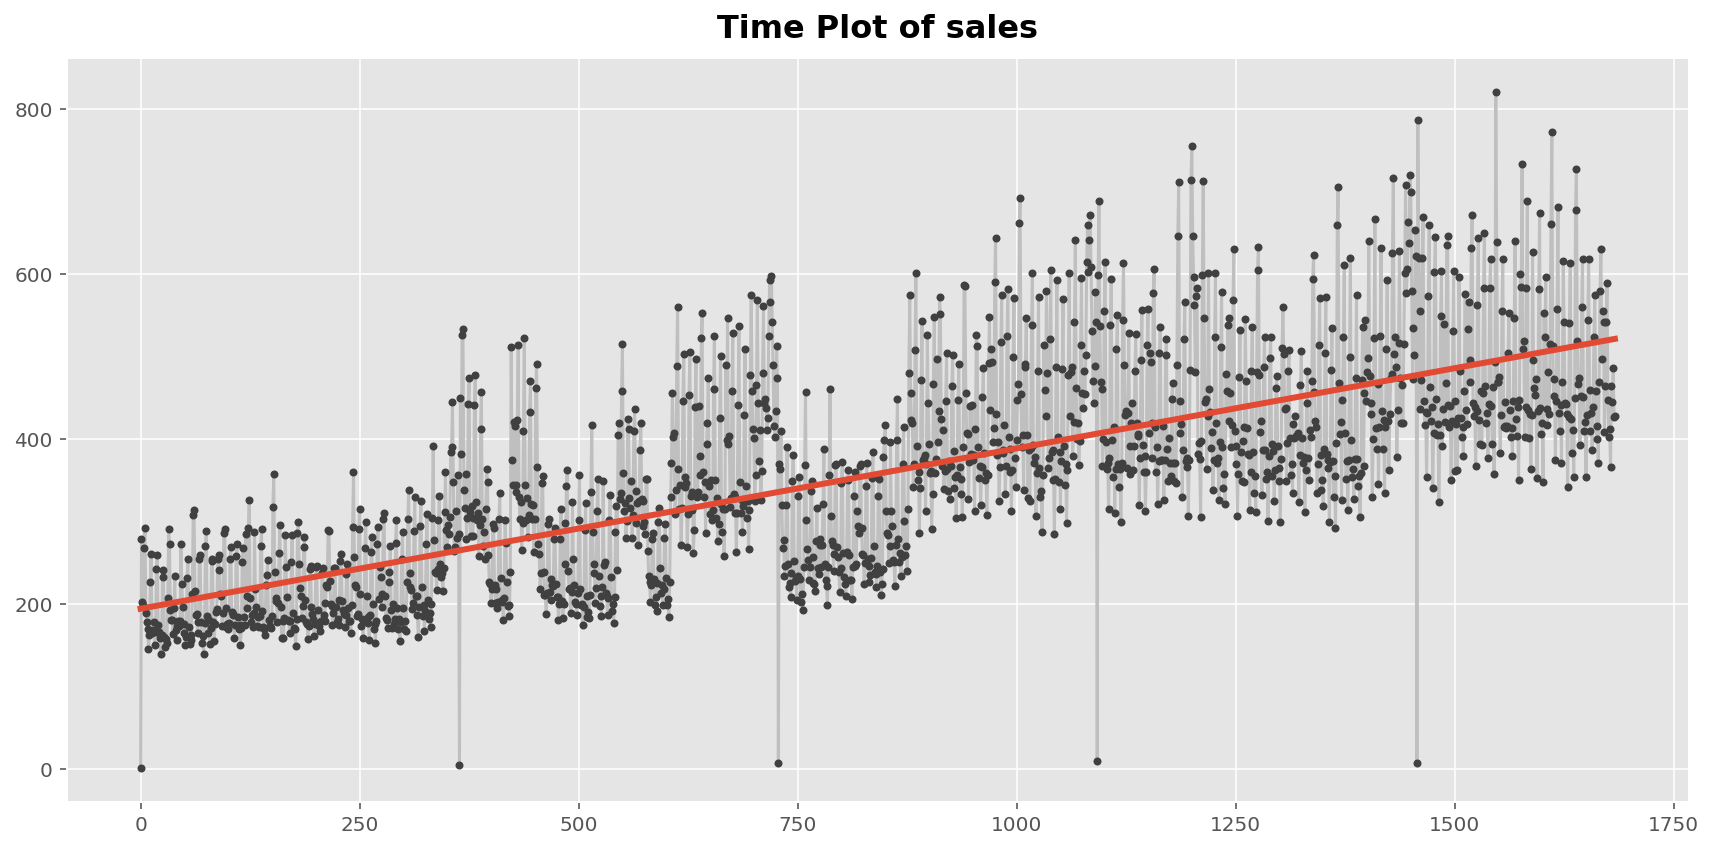

In [34]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth = 3)
ax.set_title('Time Plot of sales');

In [35]:
X = avg_sales.loc[:, ['Lag_1']]
X.dropna(inplace = True) # drop missing values in the feature set
y = avg_sales.loc[:, 'sales'] # create the target
y, X = y.align(X, join = 'inner') # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_pred

1        85.301711
2       297.268221
3       239.451339
4       236.444547
5       289.219409
           ...    
1679    363.958887
1680    439.106347
1681    424.615456
1682    455.968972
1683    410.998514
Length: 1683, dtype: float64

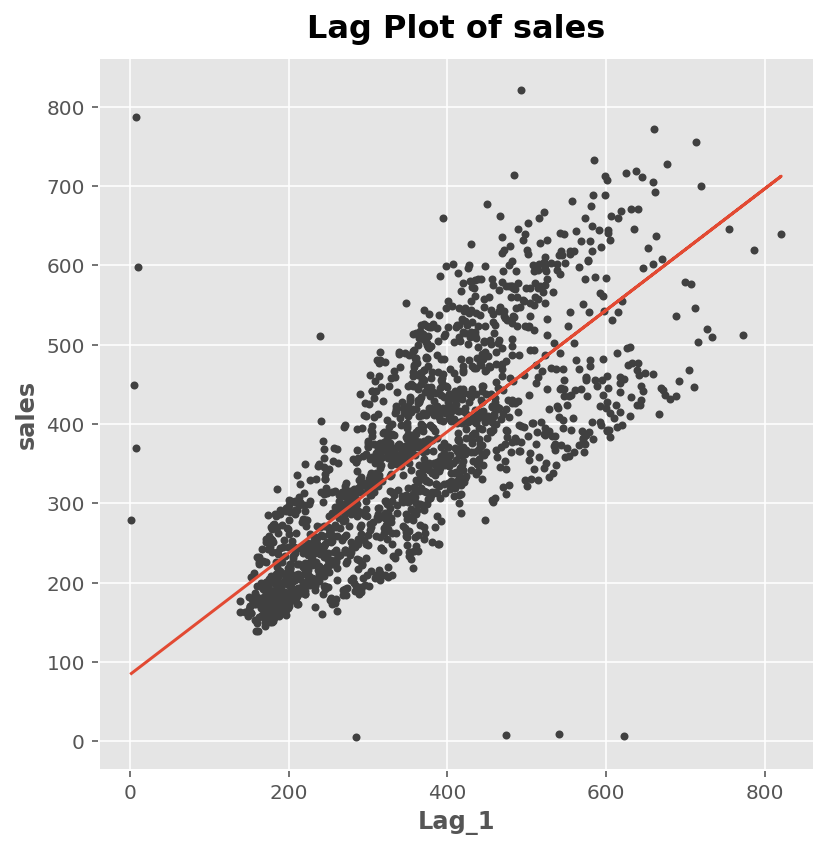

In [36]:
fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('sales')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of sales');

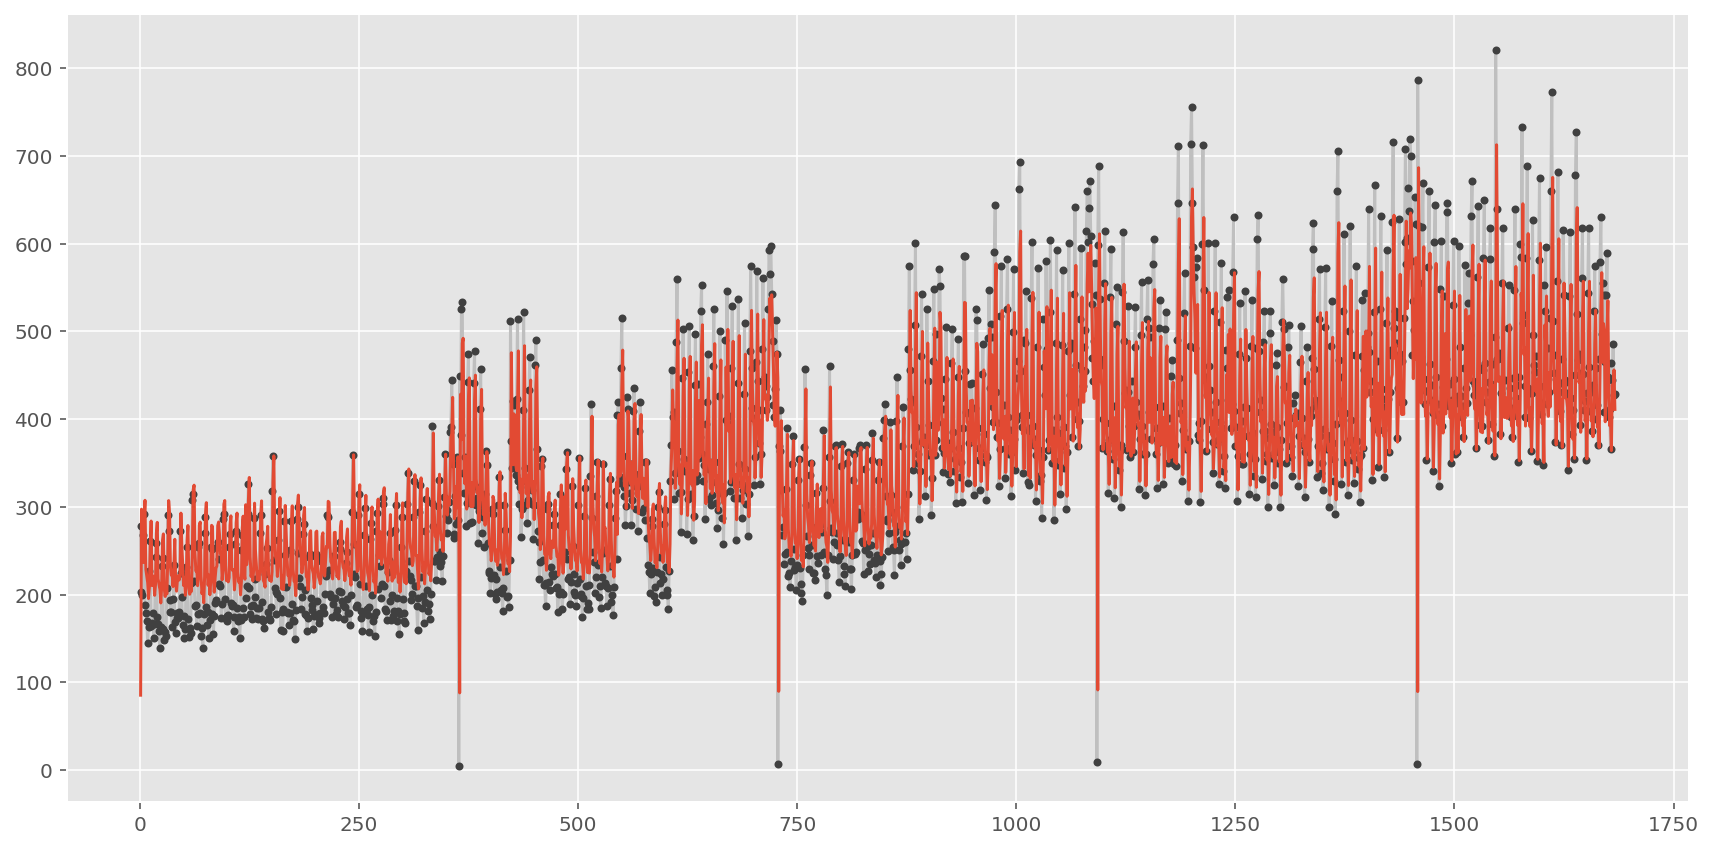

In [37]:
ax = y.plot(**plot_params)
ax = y_pred.plot()

Here, we are implementing a linear regression model to predict sales using time series data.

First, the training data is prepared, where `X` contains the time feature and `y` contains the sales target variable. The `LinearRegression()` model is then instantiated and fit to the training data using `model.fit(X, y)`. The fitted values are stored in a time series, `y_pred`.

Next, a lag plot is created by shifting the time series by one period using `Lag_1` and plotting the sales on the y-axis and `Lag_1` on the x-axis. The resulting plot can reveal if there is any autocorrelation present in the data.

## TREND

In [38]:
# Load the sales dataset

avg_sales = train_data.groupby('date').agg({'sales': 'mean'}).reset_index()
avg_sales = avg_sales.set_index('date').to_period("D")
avg_sales.head()

sales
date                  
2013-01-01    1.409438
2013-01-02  278.390807
2013-01-03  202.840197
2013-01-04  198.911154
2013-01-05  267.873244

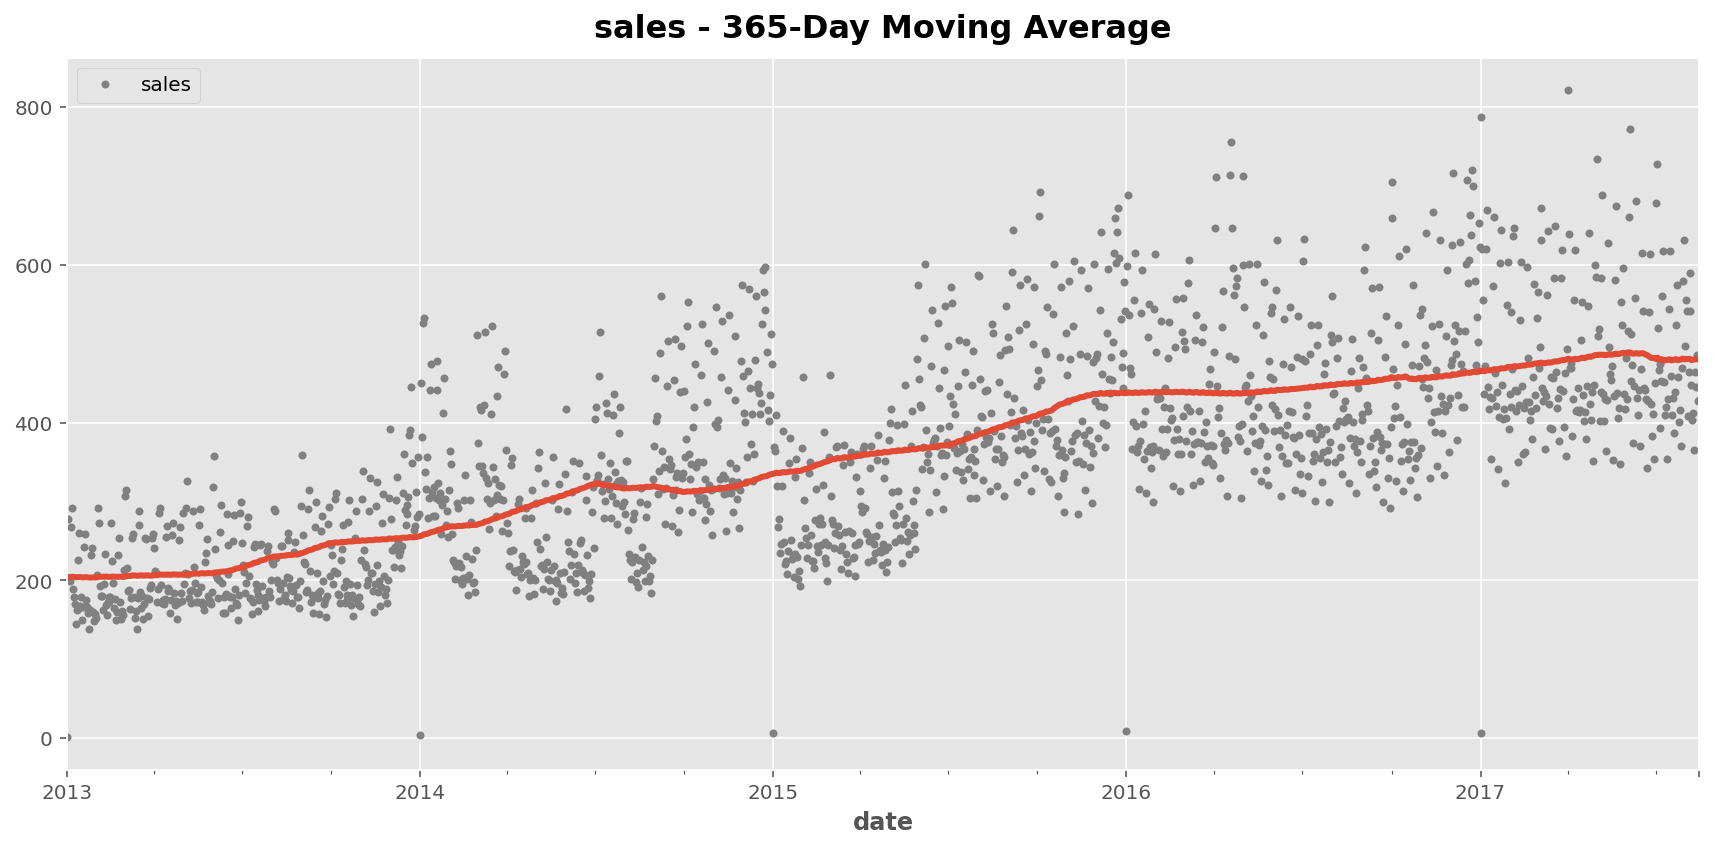

In [39]:
moving_average = avg_sales.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = avg_sales.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="sales - 365-Day Moving Average", legend=False,
);

A 365-day rolling window is applied to the daily average sales using the `rolling` function. The `center` parameter is set to `True`, which puts the computed moving average at the center of the window. The `min_periods` parameter is set to 183, which is about half of the window size, and ensures that a rolling average is only computed if at least half of the values in the window are present. Finally, the `mean()` function is called to compute the mean of the values in each window.

In [40]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=avg_sales.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

const  trend
date                    
2013-01-01    1.0    1.0
2013-01-02    1.0    2.0
2013-01-03    1.0    3.0
2013-01-04    1.0    4.0
2013-01-05    1.0    5.0

The `DeterministicProcess` from `statsmodels.tsa` is used to create a set of deterministic trend features for the time series. Specifically, it creates a set of features that represent the passage of time (e.g. linear or quadratic trend) and other deterministic components (e.g. seasonality or holiday effects).

We create a `DeterministicProcess` object with the `index` argument set to the dates from the `avg_sales` data. `constant` is set to `True` to include a dummy feature for the y-intercept, and `order` is set to 1 to include a linear trend. `drop` is set to True to drop terms if necessary to avoid collinearity.

After creating the `DeterministicProcess` object, `in_sample()` is called to generate the features for the dates given in the `index` argument. The resulting features are stored in the variable `X`. These trend features can be used to fit a regression model to predict future values of the `avg_sales` data.

In [41]:
y = avg_sales["sales"]  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

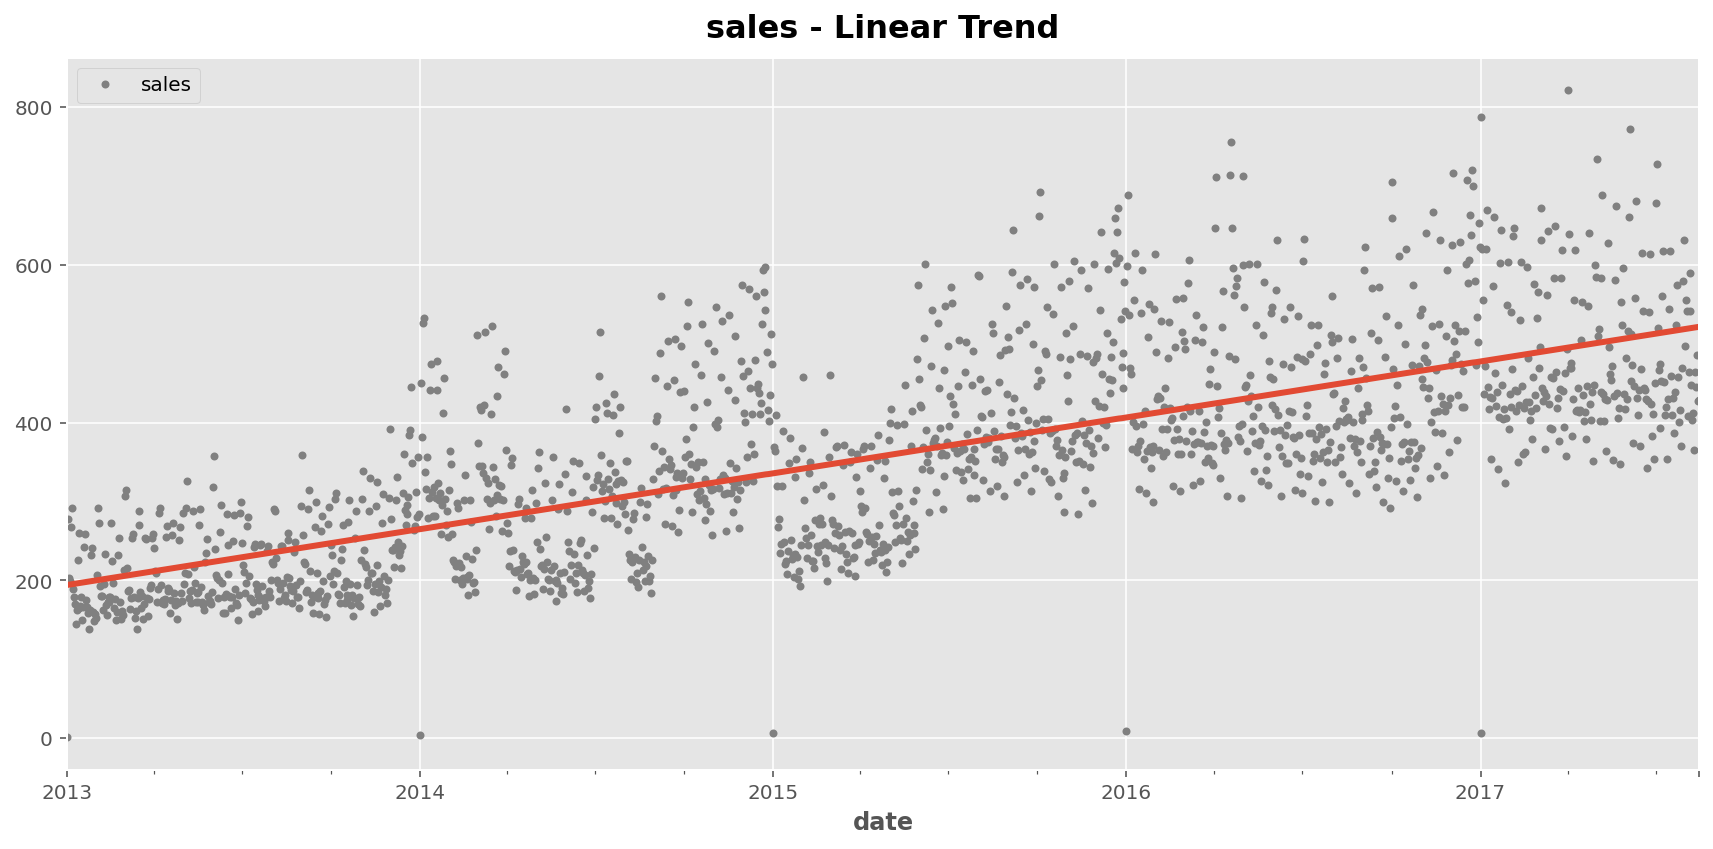

In [42]:
ax = avg_sales.plot(style=".", color="0.5", title="sales - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

In [43]:
X = dp.out_of_sample(steps=180)

y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

2017-08-16    521.513055
2017-08-17    521.707402
2017-08-18    521.901749
2017-08-19    522.096096
2017-08-20    522.290443
Freq: D, dtype: float64

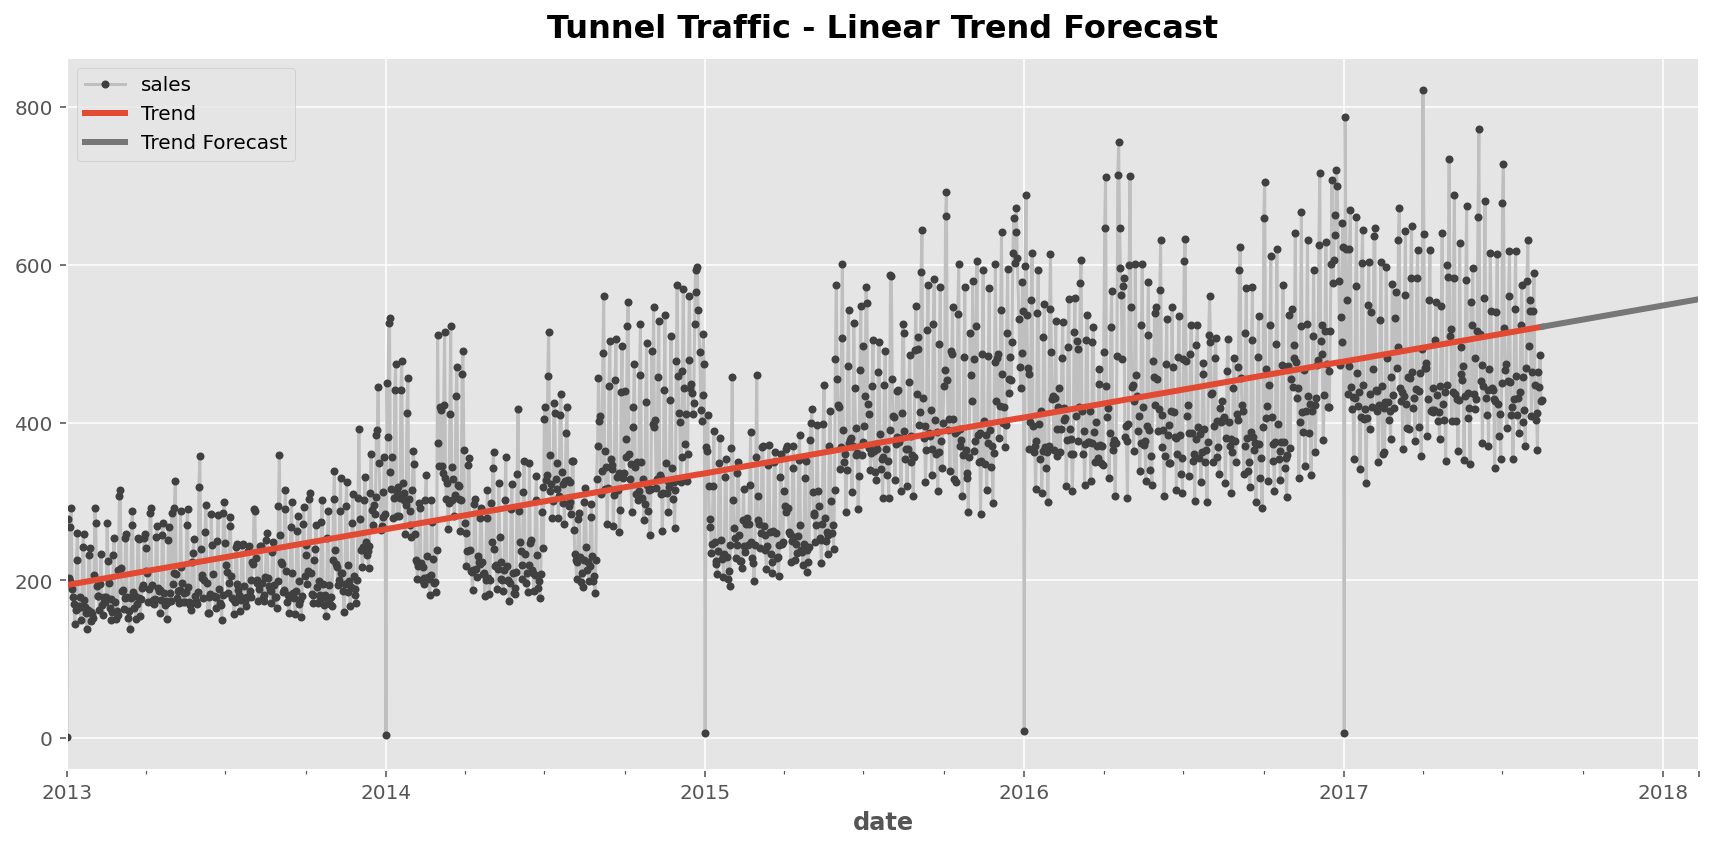

In [44]:
ax = avg_sales["2013-01":].plot(title="Tunnel Traffic - Linear Trend Forecast", **plot_params)
ax = y_pred["2013-01":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

## SEASONALITY

In [45]:
from statsmodels.tsa.deterministic import CalendarFourier

`CalendarFourier` is used to create a set of deterministic regressors for seasonality patterns in time series data. 
It creates a set of Fourier terms for each seasonal frequency of interest, such as weekly or yearly seasonality. These Fourier terms can be used in a regression model to capture the seasonal patterns in the data. 

In [46]:
# annotations: https://stackoverflow.com/a/49238256/5769929

def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

# Load the sales dataset
avg_sales = train_data.groupby('date').agg({'sales': 'mean'}).reset_index()
avg_sales = avg_sales.set_index('date').to_period("D")
avg_sales.head()

sales
date                  
2013-01-01    1.409438
2013-01-02  278.390807
2013-01-03  202.840197
2013-01-04  198.911154
2013-01-05  267.873244

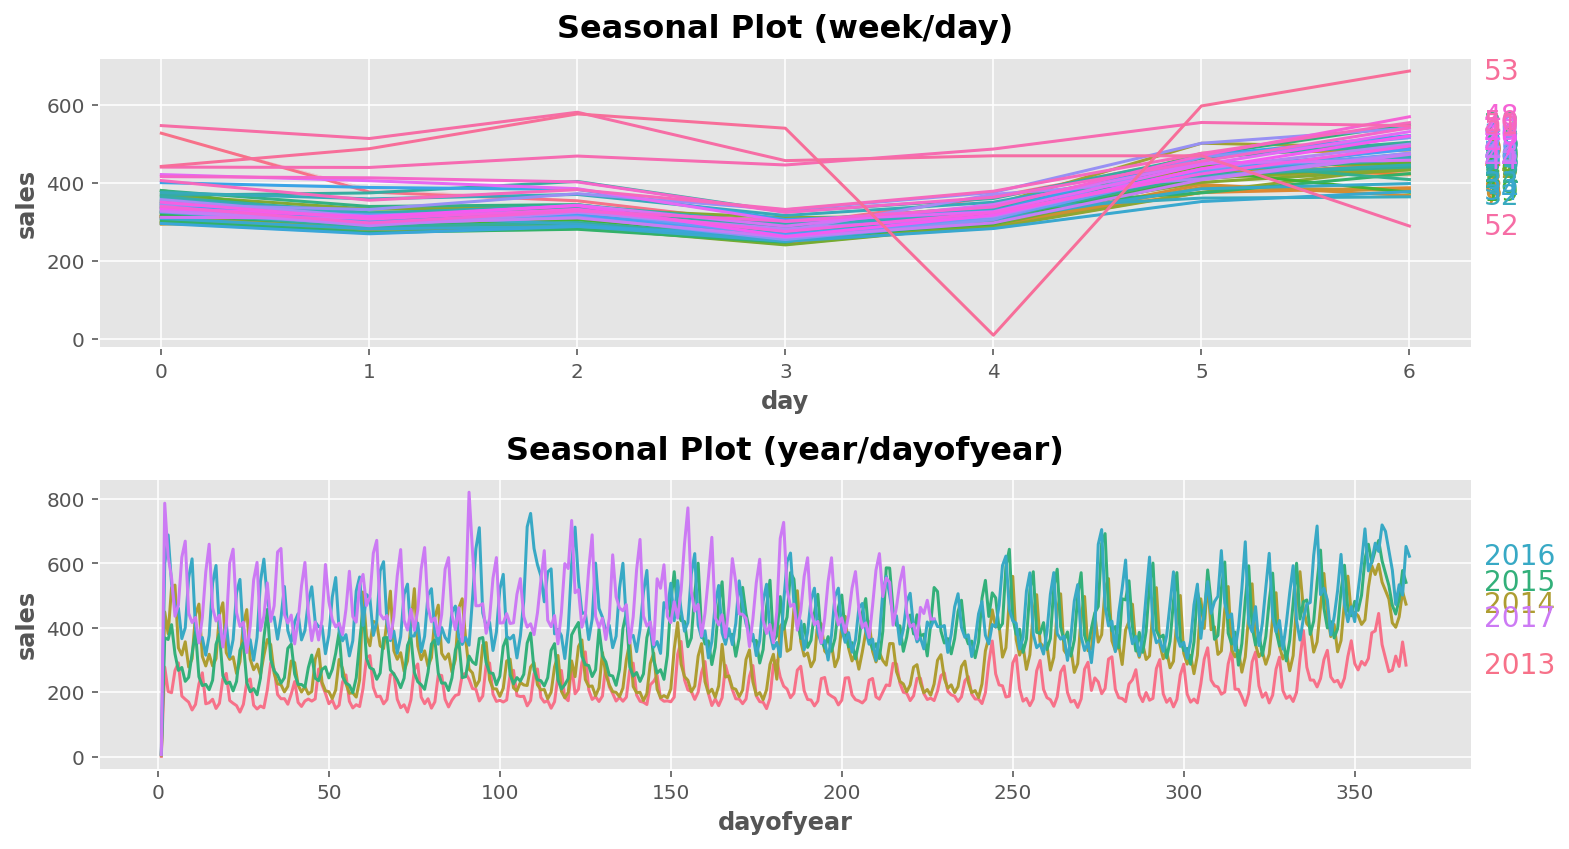

In [47]:
X = avg_sales.copy()

# days within a week
X['day'] = X.index.dayofweek # the x-axis (freq)
X['week'] = X.index.week # the seasonal period (period)

# days within a year
X['dayofyear'] = X.index.dayofyear
X['year'] = X.index.year

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="sales", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="sales", period="year", freq="dayofyear", ax=ax1);

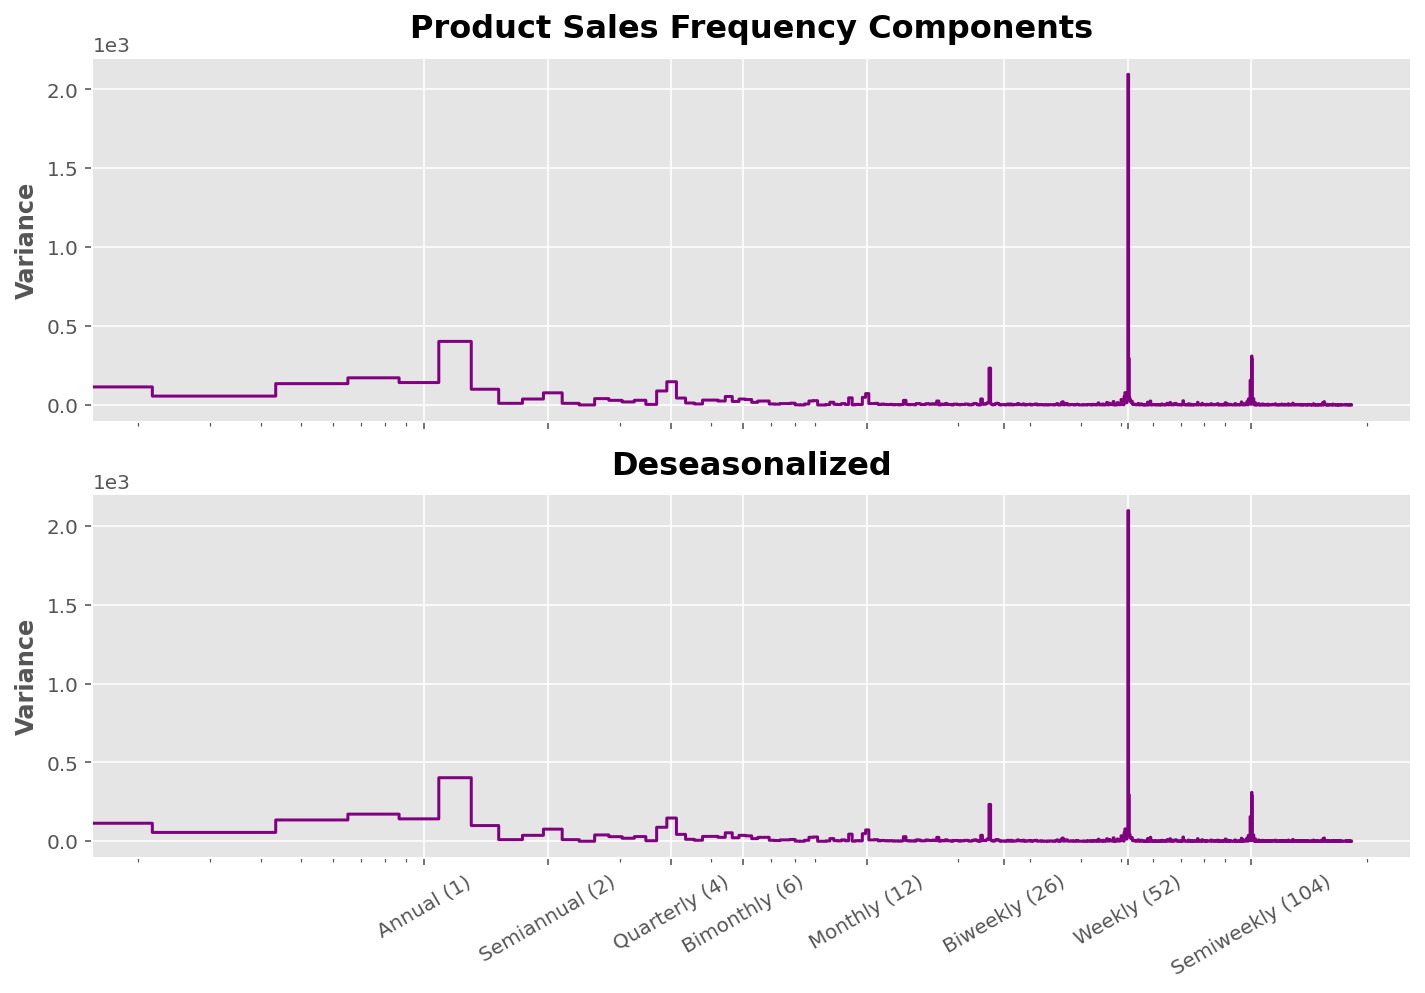

In [48]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

In [49]:
fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=avg_sales.index,
    constant=True,   # dummy feature for bias (y-intercept)
    order=1,         # trend ( order 1 means linear)
    seasonal=True,   # weekly seasonality (indicators)
    additional_terms=[fourier], # annual seasonality
    drop=True,       # drop terms to avoid collinearity
)

X = dp.in_sample() # create features for dates in tunnel.index
#X.head()

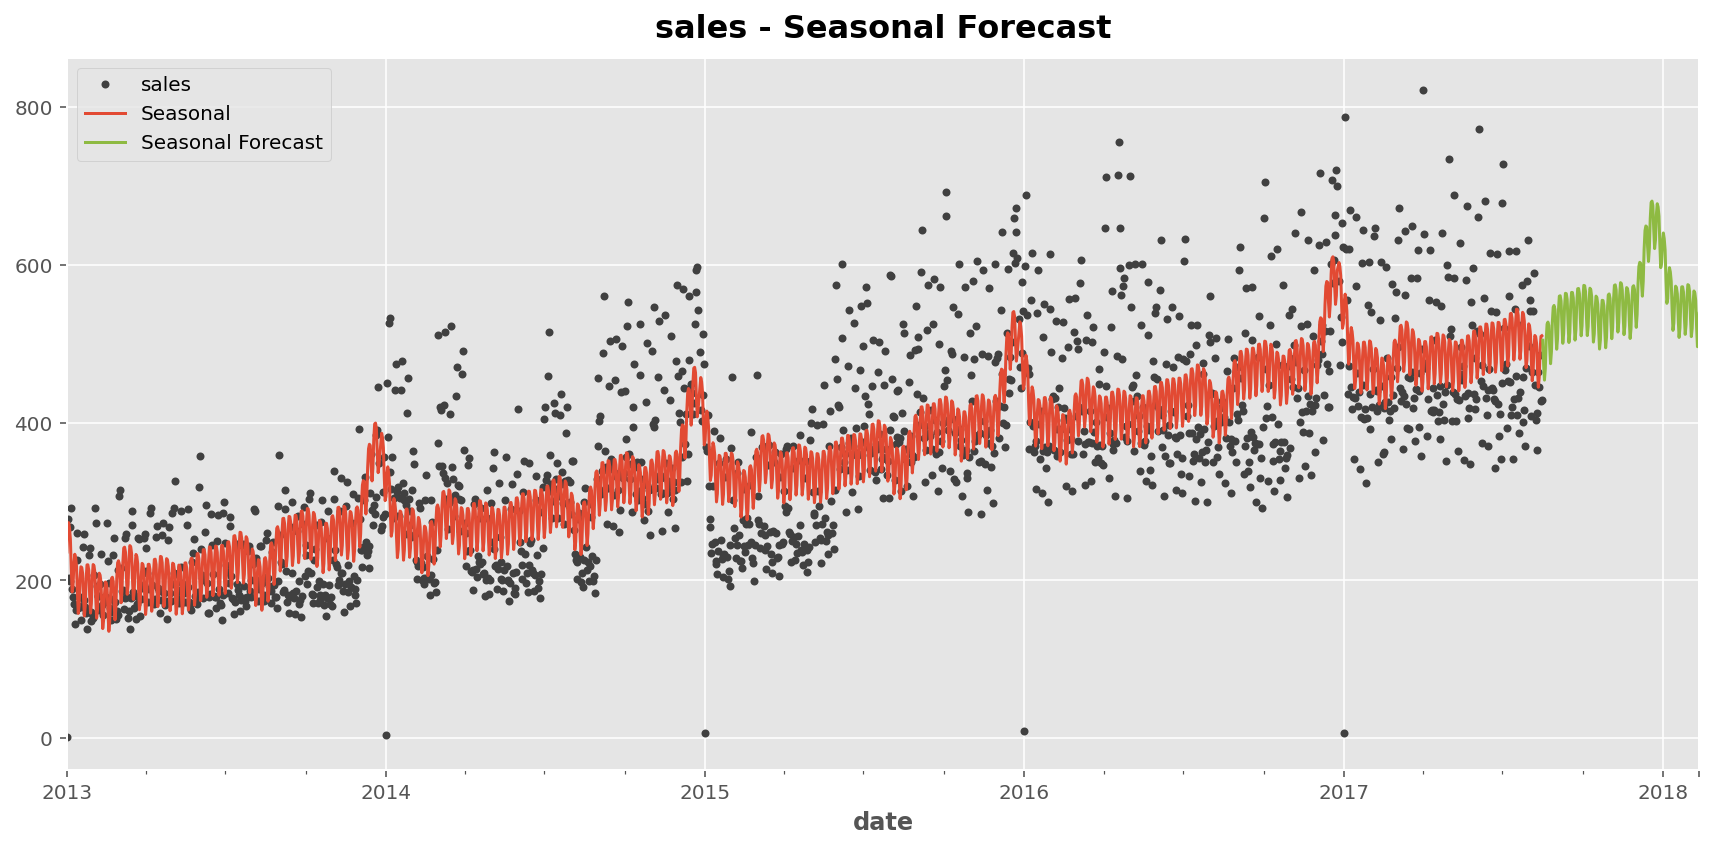

In [50]:
y = avg_sales["sales"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=180)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="sales - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C5')
_ = ax.legend()

In [51]:
holidays_events = pd.read_csv(
    "/content/holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool'
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

holidays_events = holidays_events.set_index('date').to_period('D')

# National and regional holidays in the training set
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

display(holidays)

description
date                                              
2017-01-01                      Primer dia del ano
2017-01-02             Traslado Primer dia del ano
2017-02-27                                Carnaval
2017-02-28                                Carnaval
2017-04-01           Provincializacion de Cotopaxi
2017-04-14                           Viernes Santo
2017-05-01                         Dia del Trabajo
2017-05-13                       Dia de la Madre-1
2017-05-14                         Dia de la Madre
2017-05-24                    Batalla de Pichincha
2017-05-26           Traslado Batalla de Pichincha
2017-06-25           Provincializacion de Imbabura
2017-08-10           Primer Grito de Independencia
2017-08-11  Traslado Primer Grito de Independencia

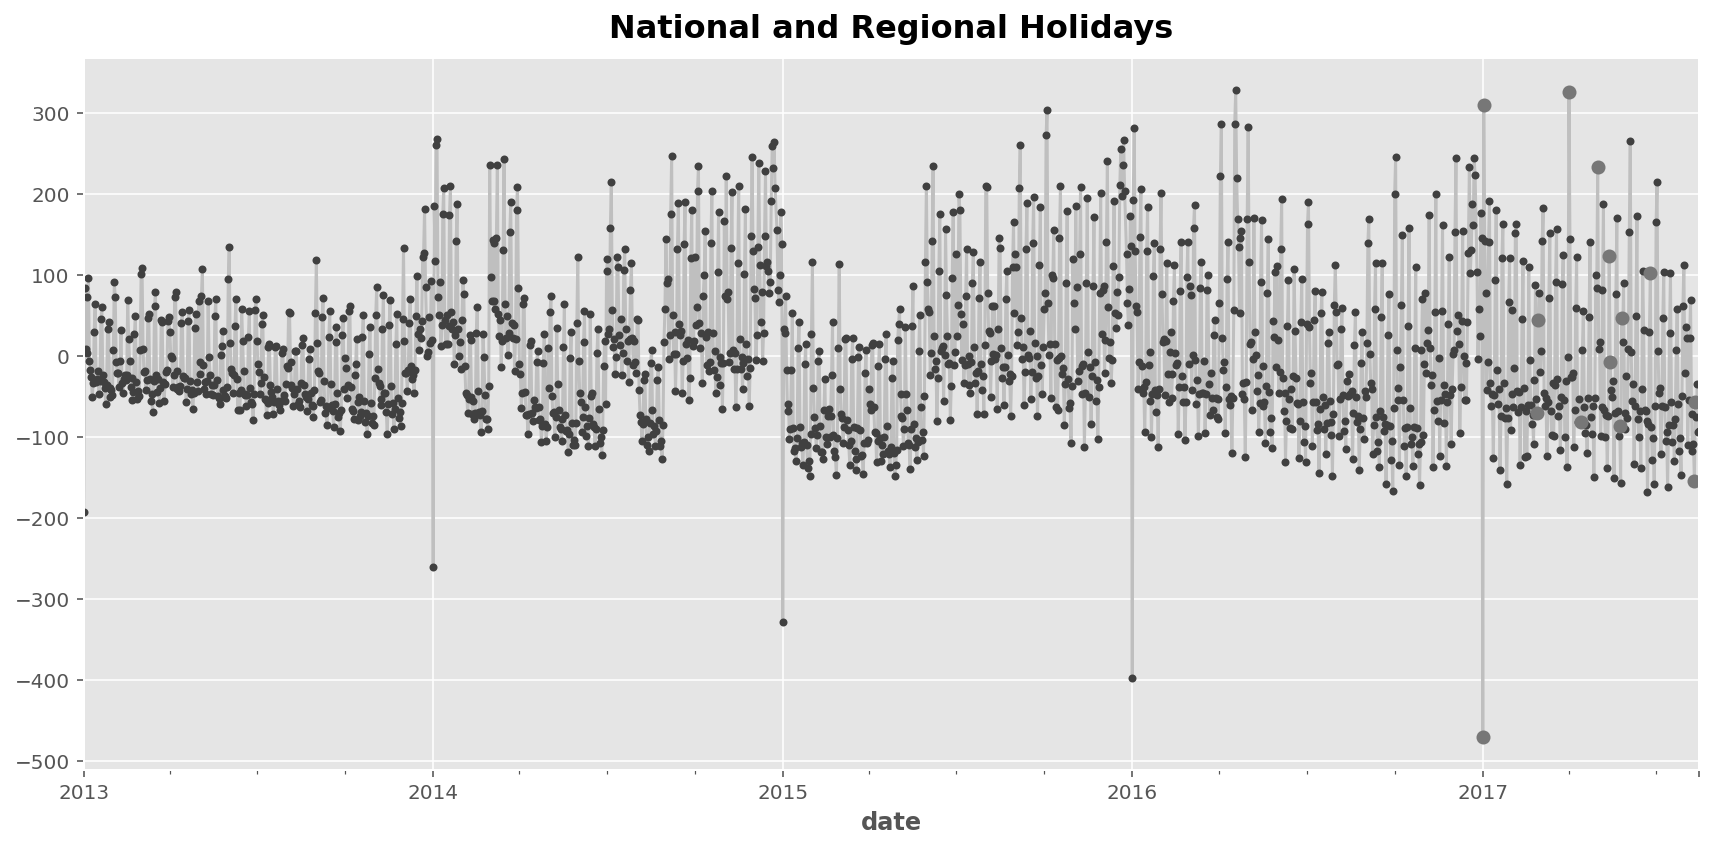

In [52]:
ax = y_deseason.plot(**plot_params)
plt.plot_date(holidays.index, y_deseason[holidays.index], color='C3')
ax.set_title('National and Regional Holidays');

In [53]:
X_holidays = pd.get_dummies(holidays)

# Join to training data
X2 = X.join(X_holidays, on='date').fillna(0.0)

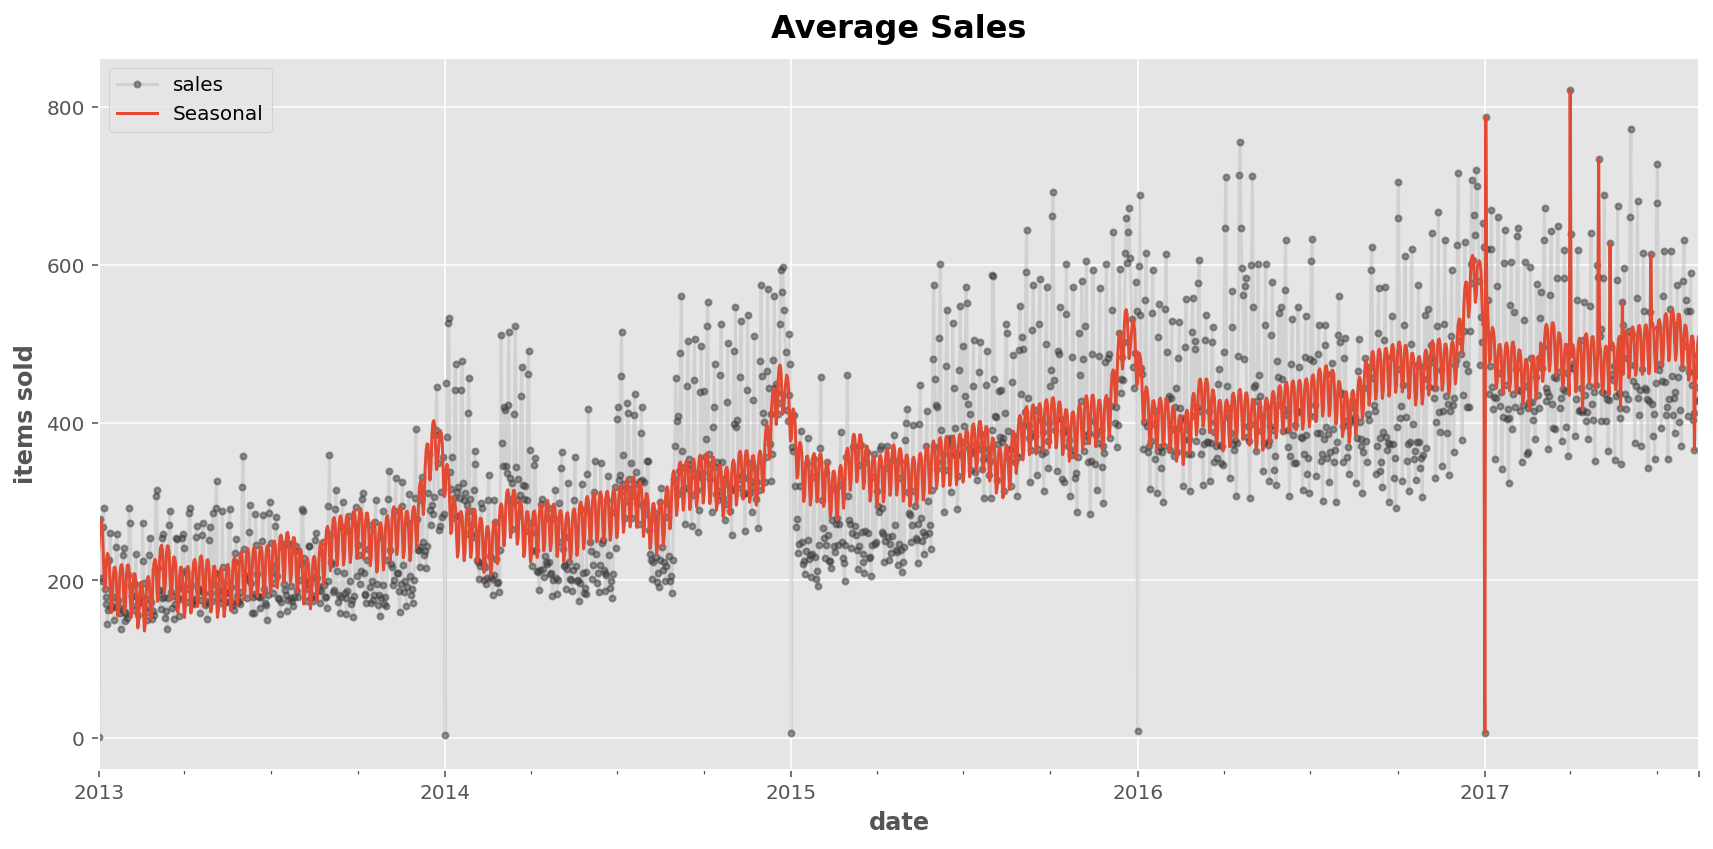

In [54]:
model = LinearRegression().fit(X2, y)
y_pred = pd.Series(
    model.predict(X2),
    index=X2.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X2), index=X2.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

In [55]:
store_sales = pd.read_csv(
    "/content/train.csv",
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

y = store_sales.unstack(['store_nbr', 'family']).loc["2017"]

# Create training data
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

CategoricalIndex(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
                  'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI',
                  'EGGS', 'FROZEN FOODS', 'GROCERY I', 'GROCERY II',
                  'HARDWARE', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II',
                  'HOME APPLIANCES', 'HOME CARE', 'LADIESWEAR',
                  'LAWN AND GARDEN', 'LINGERIE', 'LIQUOR,WINE,BEER',
                  'MAGAZINES', 'MEATS', 'PERSONAL CARE', 'PET SUPPLIES',
                  'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS',
                  'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'],
                 categories=['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', 'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', ...], ordered=False, dtype='category', name='family')

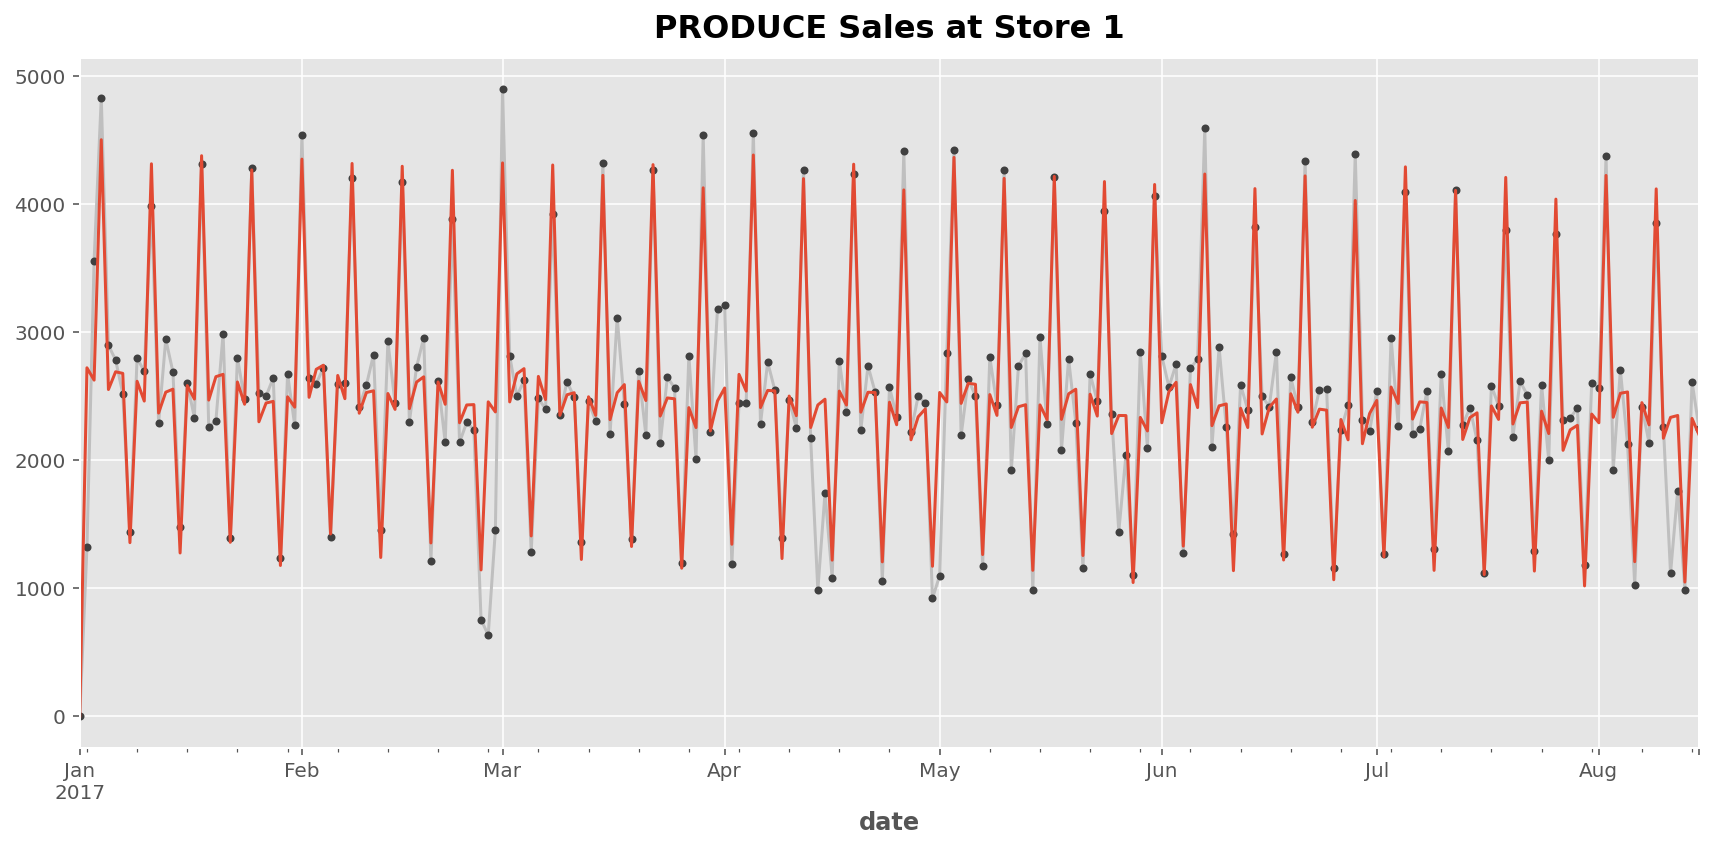

In [56]:
STORE_NBR = '1'  # 1 - 54
FAMILY = 'PRODUCE'
# Uncomment to see a list of product families
display(store_sales.index.get_level_values('family').unique())

ax = y.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(**plot_params)
ax = y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');

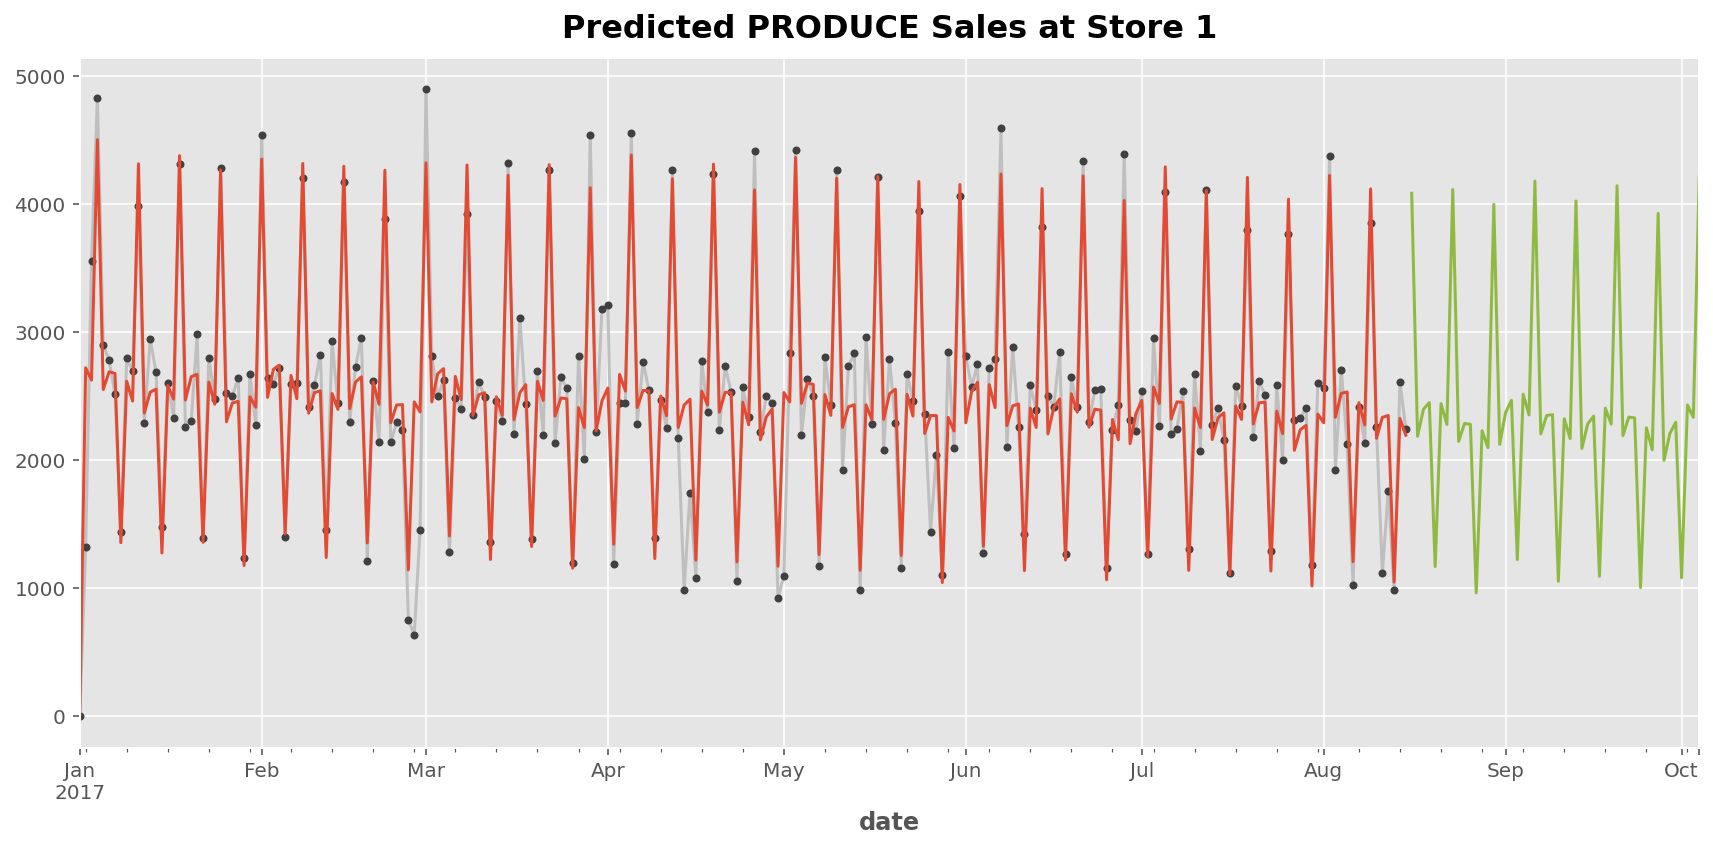

In [57]:
df_test = pd.read_csv(
    '/content/test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

# Create features for test set
X_test = dp.out_of_sample(steps=50)
X_test.index.name = 'date'
X_test['NewYear'] = (X_test.index.dayofyear == 1)

y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

ax = y.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(**plot_params)
ax = y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)
ax = y_submit.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax, color='C5')
ax.set_title(f'Predicted {FAMILY} Sales at Store {STORE_NBR}');

## HYBRID MODELS

In [58]:
store_sales = pd.read_csv(
    "/content/train.csv",
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

In [59]:
family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017']
)

family_sales.head()

sales                                              \
family     AUTOMOTIVE BABY CARE     BEAUTY    BEVERAGES     BOOKS   
date                                                                
2017-01-01   0.092593  0.037037   0.055556    74.222221  0.000000   
2017-01-02  11.481482  0.259259  11.648149  6208.055664  0.481481   
2017-01-03   8.296296  0.296296   7.185185  4507.814941  0.814815   
2017-01-04   6.833333  0.333333   6.888889  3911.833252  0.759259   
2017-01-05   6.333333  0.351852   5.925926  3258.796387  0.407407   

                                                                           \
family     BREAD/BAKERY CELEBRATION     CLEANING        DAIRY        DELI   
date                                                                        
2017-01-01     9.084685    0.129630     7.500000    11.518518    3.629167   
2017-01-02   844.836304   14.203704  2233.648193  1545.000000  539.114807   
2017-01-03   665.124084   10.629630  1711.907349  1204.203735  404.300079   
2017-01-04   594.160583   11.185185  1508.036987  1107.796265  309.397675   
2017-01-05   495.511597   12.444445  1241.833374   829.277771  260.776489   

            ... onpromotion                                       \
family      ...   MAGAZINES     MEATS PERSONAL CARE PET SUPPLIES   
date        ...                                                    
2017-01-01  ...         0.0  0.018519      0.111111     0.018519   
2017-01-02  ...         0.0  0.462963     10.592593     0.537037   
2017-01-03  ...         0.0  0.481481      9.722222     0.444444   
2017-01-04  ...         0.0  0.370370     12.037037     0.444444   
2017-01-05  ...         0.0  8.981481      5.666667     0.000000   

                                                                         \
family     PLAYERS AND ELECTRONICS   POULTRY PREPARED FOODS     PRODUCE   
date                                                                      
2017-01-01                     0.0  0.000000       0.037037    0.129630   
2017-01-02                     0.0  0.259259       1.166667    5.629630   
2017-01-03                     0.0  0.388889       1.351852   56.296296   
2017-01-04                     0.0  0.296296       5.444444  101.277778   
2017-01-05                     0.0  0.296296       0.907407    5.018519   

                                                 
family     SCHOOL AND OFFICE SUPPLIES   SEAFOOD  
date                                             
2017-01-01                        0.0  0.000000  
2017-01-02                        0.0  0.407407  
2017-01-03                        0.0  0.407407  
2017-01-04                        0.0  0.333333  
2017-01-05                        0.0  0.444444  

[5 rows x 66 columns]

In [60]:
class BoostedHybrid:

    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method

    def fit(self, X_1, X_2, y):
        # Train model_1
        self.model_1.fit(X_1, y)

        # Make predictions
        y_fit = pd.DataFrame(
            self.model_1.predict(X_1), 
            index=X_1.index, 
            columns=y.columns,
        )

        # Compute residuals
        y_resid = y - y_fit
        y_resid = y_resid.stack().squeeze() # wide to long

        # Train model_2 on residuals
        self.model_2.fit(X_2, y_resid)

        # Save column names for predict method
        self.y_columns = y.columns
        # Save data for question checking
        self.y_fit = y_fit
        self.y_resid = y_resid

    def predict(self, X_1, X_2):
        # Predict with model_1
        y_pred = pd.DataFrame(
            self.model_1.predict(X_1), 
            index=X_1.index, columns=self.y_columns,
        )
        y_pred = y_pred.stack().squeeze()  # wide to long

        # Add model_2 predictions to model_1 predictions
        y_pred += self.model_2.predict(X_2)

        return y_pred.unstack()

The `BoostedHybrid` class is designed to combine the predictions of two separate models in order to create a more accurate prediction for a target variable. The class takes two pre-trained models as arguments during initialization, `model_1` and `model_2`. The fit method takes in three arguments, `X_1`, `X_2`, and `y`, which represent the feature matrices for `model_1`, `model_2`, and the target variable, respectively. The `fit` method trains the first model, `model_1`, on the feature matrix `X_1`, and then uses this model to make predictions on the target variable, `y`. The residuals of this prediction are then computed and used to train `model_2` on the feature matrix `X_2`. The `predict` method takes in `X_1` and `X_2` and produces predictions by using `model_1` to predict the target variable and then adding the predictions from `model_2`. This process combines the strengths of two models to create more accurate predictions.

In [61]:
from sklearn.preprocessing import LabelEncoder

# Target series
y = family_sales.loc[:, 'sales']


# X_1: Features for Linear Regression
dp = DeterministicProcess(index=y.index, order=1)
X_1 = dp.in_sample()


# X_2: Features for XGBoost
X_2 = family_sales.drop('sales', axis=1).stack()  # onpromotion feature


# Label encoding for 'family'
le = LabelEncoder()  # from sklearn.preprocessing
X_2 = X_2.reset_index('family')
X_2['family'] = le.fit_transform(X_2['family'])

# Label encoding for seasonality
X_2["day"] = X_2.index.day  # values are day of the month

In [62]:
from xgboost import XGBRegressor

# Linear Regression + XGBRegressor
model = BoostedHybrid(
    model_1 = LinearRegression(),
    model_2 = XGBRegressor(),
)

model.fit(X_1, X_2, y)
y_pred = model.predict(X_1, X_2)

y_pred = y_pred.clip(0.0)

In [63]:
# Model 1 (trend)
from pyearth import Earth
from sklearn.linear_model import ElasticNet, Lasso, Ridge

# Model 2
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

In [64]:
# Boosted Hybrid

# Try different combinations of the algorithms above
model = BoostedHybrid(
    model_1=Ridge(),
    model_2=KNeighborsRegressor(),
)

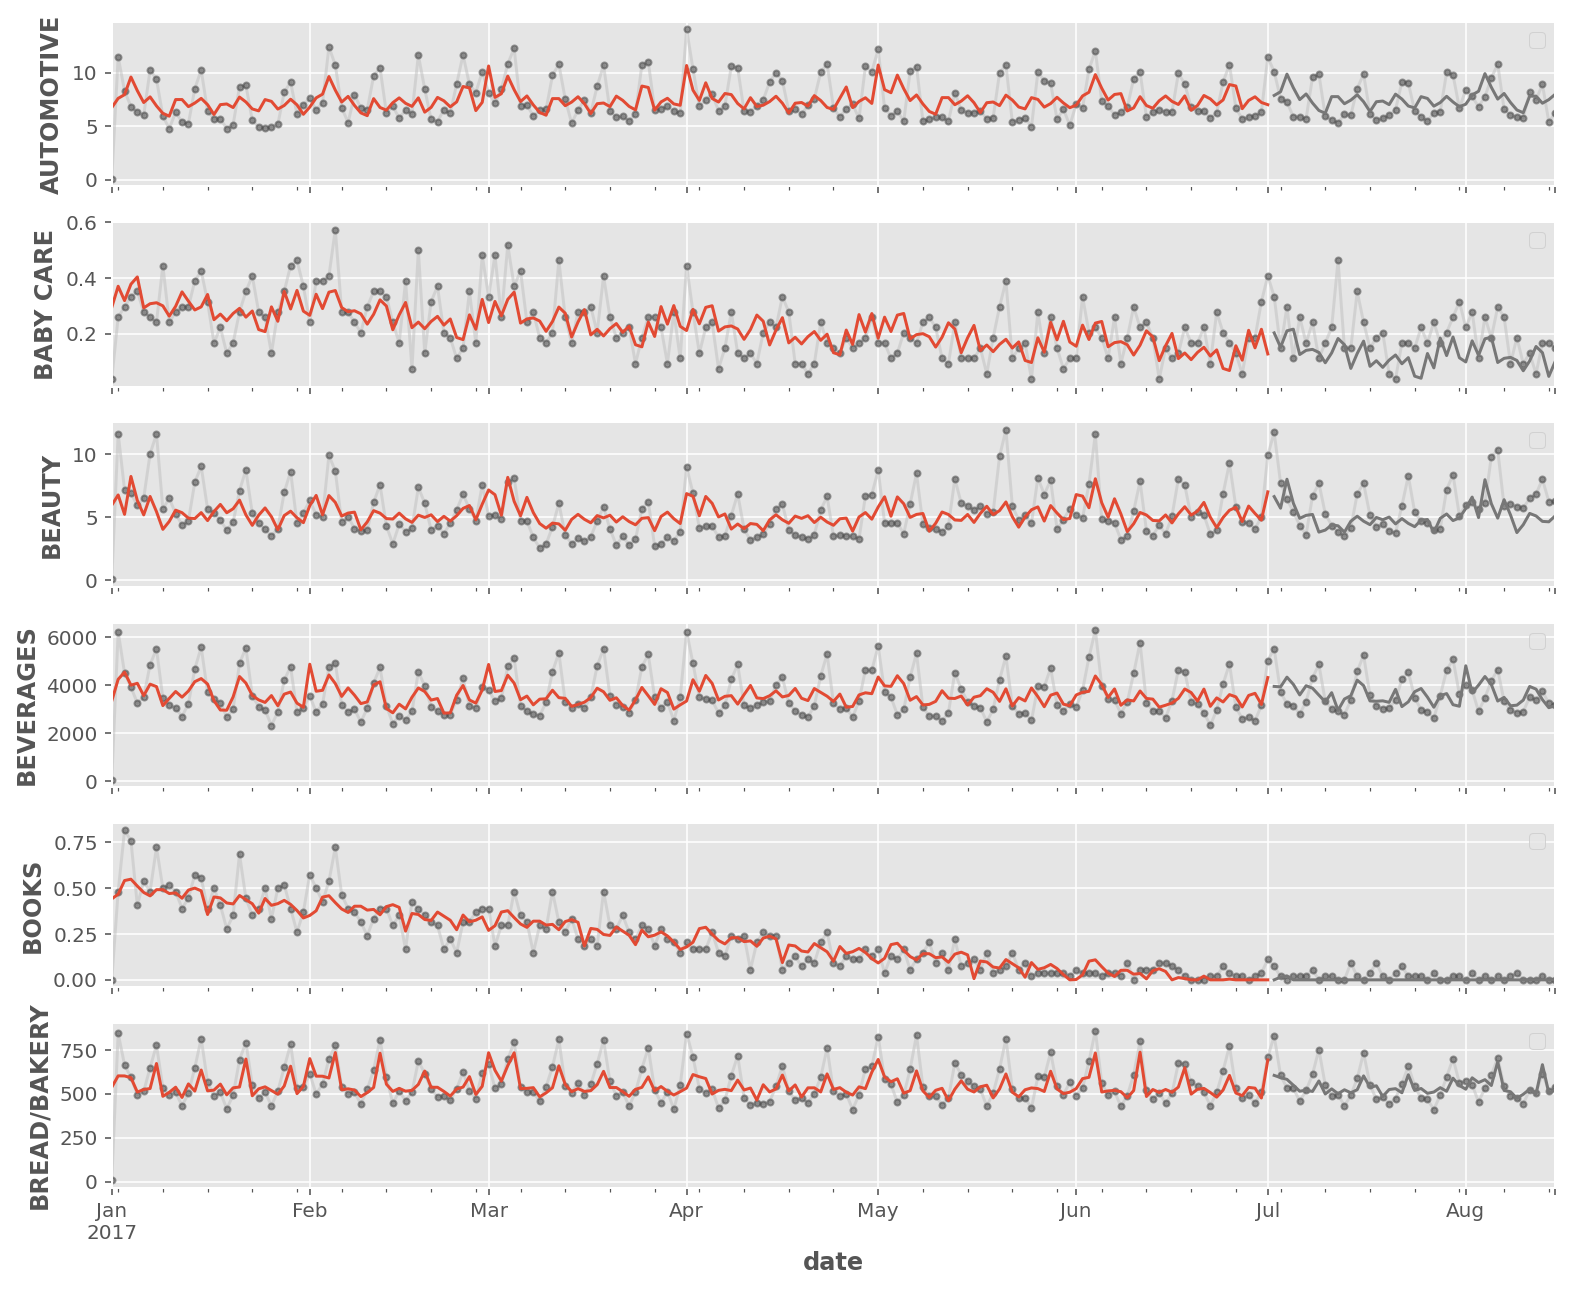

In [65]:
from sklearn.preprocessing import StandardScaler

y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
X1_train, X1_valid = X_1[: "2017-07-01"], X_1["2017-07-02" :]
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]

# Some of the algorithms above do best with certain kinds of
# preprocessing on the features (like standardization)
scaler = StandardScaler()
for data in (X2_train, X2_valid):
    data['onpromotion'] = scaler.fit_transform(data[['onpromotion']])

model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)

families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(11, 9), **plot_params, alpha=0.5,
)
_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)